In [50]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import math
import os
import glob

# Interactive plotting
# %matplotlib widget

plt.style.use("ggplot")

# Estimate river fluxes

Taking clean river discharge data (output of notebook q2_clean_discharge_data) and estimated daily concentrations of the variables of interest (from notebook flux2). Multiply these together (taking care of the units) to estimate daily, monthly and annual fluxes to the Oslofjord from the three big rivers.

**Discuss with Helene how to save the results.** E.g. one csv per river of daily fluxes?

Also plot daily, monthly and annual fluxes

### 0. Parameters

In [24]:
water_chemistry_file_path = '../../data/river/water_chem/estimations/water_chem_daily_estimations.csv'
discharges_path = '../../data/river/discharge/clean'

flux_folder = r'../../data/river/fluxes'

date_variable = 'Date'
discharge_variable =  'Discharge'
station_name = 'station_name'
station_id = 'station_id'

river_names_mapper = {
    'Q_daily-mean_Drammenselva_Mjøndalen bru_12': 'discharge_Drammenselva v/Krokstadelva',
    'Q_daily-mean_Glomma_Solbergfoss_2': 'discharge_Glomma v/Sarpefossen',
    'Q_daily-mean_Numedalslågen_Holmfoss_15': 'discharge_Numedalslågen v/E18'
}

short_site_li = {'Drammenselva v/Krokstadelva': 'Drammenselva',
                 'Glomma v/Sarpefossen': 'Glomma',
                 'Numedalslågen v/E18': 'Numedalslagen'
}

## Read in

LJB: suggestions for extra things to do:
- The joining of chem and Q data you did in the previous notebook because you were looking into using Q to estimate daily chem. But it would probably be cleaner/more generalizable to just save chem variables in the chem processing notebooks (i.e. not discharge too). Then in this notebook we take daily concentration estimates (estimated using whatever method...), also read in daily cleaned discharge, then join them and estimate fluxes
- In previous chem notebook, could also save a df with just the estimated daily chem (i.e. without the suffix and drop the _raw data). Then you could have a version of this notebook that doesn't include raw and estimated versions of each variable. i.e. just one column per variable. This would make it easier to just loop through all columns in what would be something like chem_df and calculate fluxes for all of them, plot all of them, i.e. treat each column equally. Though it's nice to plot spot flux observations together with estimated, so keep your plotting function somewhere, so it can be used if this notebook is run using input csv data that does include both estimated and raw data?

In [21]:
chem_df = pd.read_csv(water_chemistry_file_path)
chem_df[date_variable] = pd.to_datetime(chem_df[date_variable])

csv_files = glob.glob(os.path.join(discharges_path, '*.csv'))

discharge_df = pd.DataFrame()

for file in csv_files:
    river_name = os.path.basename(file).split('.')[0]
    
    df = pd.read_csv(file)
    
    discharge_column = df[[date_variable, discharge_variable]].rename(columns={discharge_variable: river_names_mapper[river_name]})
    
    if discharge_df.empty:
        discharge_df = discharge_column
    else:
        discharge_df = pd.merge(discharge_df, discharge_column, on=date_variable, how='outer')

discharge_df[date_variable] = pd.to_datetime(discharge_df[date_variable])
discharge_df.head()


,Date,discharge_Glomma v/Sarpefossen,discharge_Drammenselva v/Krokstadelva,discharge_Numedalslågen v/E18
0,1990-01-01,425.0,264.681,75.875
1,1990-01-02,500.0,264.681,75.160
2,1990-01-03,500.0,260.214,73.044
3,1990-01-04,500.0,260.214,75.160
4,1990-01-05,472.0,260.214,81.769


In [22]:
## Merge chemistry and discharges in a single df

discharge_long_df = discharge_df.melt(id_vars=[date_variable], 
                                      var_name=station_name, 
                                      value_name=discharge_variable)

discharge_long_df[station_name] = discharge_long_df[station_name].str.replace('discharge_', '')

discharge_long_df[date_variable] = pd.to_datetime(discharge_long_df[date_variable])

chem_df.reset_index(inplace=True)
chem_df[date_variable] = chem_df[date_variable].dt.date
chem_df.rename(columns={date_variable: date_variable}, inplace=True)
chem_df[date_variable] = pd.to_datetime(chem_df[date_variable])

merged_df = pd.merge(discharge_long_df, chem_df, on=[date_variable, station_name], how='left')

merged_df[date_variable] = pd.to_datetime(merged_df[date_variable])
merged_df.head()

,Date,station_name,Discharge,index,Farge_mg Pt/l_est,DIN_μg/l_est,PO4-P_µg/l_est,SiO2_mg/l_est,TOC_mg/l_est,TOTN_µg/l_est,TOTP/F_µg/l P_est,TOTP_P_µg/l P_est,TOTP_µg/l_est,TSM_mg/l_est,UV-Abs. 410nm_Abs/cm_est,UV-Abs. 254nm_Abs/cm_est
0,1990-01-01,Glomma v/Sarpefossen,425.0,12658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-01-02,Glomma v/Sarpefossen,500.0,12659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1990-01-03,Glomma v/Sarpefossen,500.0,12660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1990-01-04,Glomma v/Sarpefossen,500.0,12661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1990-01-05,Glomma v/Sarpefossen,472.0,12662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# LJB: don't think we need to define the variables, we should just be able to loop through all concentration columns present in the df (more generalisable then)
# To do: having separate colls for _raw and _est is a bit messy. Move this to a separate "research" notebook?
# Version for galaxy should probably just be daily estimated, and then you don't need the suffix at all

site_li = merged_df['station_name'].unique()

In [26]:
# Extract data for each site and store in dictionary, setting datetime index

# LJB: instead of doing for each river separately and calling dfs glomma_df, etc., it's more flexible to 
# make a dictionary, loop through sites, save results in the dict (e.g. if we end up with 10 sites later, or site names change)
# Same for daily, monthly and annual fluxes, so I quickly altered that code below too. I sorted the date column out here
# (save to index), so we don't have to worry about doing that multiple times below)

chem_df_dict = {}

for site in site_li:
    chem_station_df = merged_df[merged_df['station_name'] == site].copy()
    
    if 'Date' not in chem_station_df.columns:
        chem_station_df = chem_station_df.reset_index()
    
    chem_station_df['Date'] = pd.to_datetime(chem_station_df['Date'])
    chem_station_df.set_index('Date', inplace=True)
    chem_station_df.drop('station_name', axis=1, inplace=True)

    # Save in dictionary
    chem_df_dict[site] = chem_station_df

chem_station_df.head()

,Discharge,index,Farge_mg Pt/l_est,DIN_μg/l_est,PO4-P_µg/l_est,SiO2_mg/l_est,TOC_mg/l_est,TOTN_µg/l_est,TOTP/F_µg/l P_est,TOTP_P_µg/l P_est,TOTP_µg/l_est,TSM_mg/l_est,UV-Abs. 410nm_Abs/cm_est,UV-Abs. 254nm_Abs/cm_est
Date,,,,,,,,,,,,,,
1990-01-01,75.875,25316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-02,75.160,25317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,73.044,25318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,75.160,25319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,81.769,25320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Estimate fluxes

### Daily fluxes

In [36]:
def compute_fluxes(df):
    q_m3_per_day = df[discharge_variable] * 86400  # m³/s to m³/day

    flux_df = pd.DataFrame(index=df.index)

    # Convert concentration to kg/m³
    for col in df.columns.drop([discharge_variable, "index"]):
        if 'mg/l' in col or 'mg Pt/l' in col:
            concentration_kg_per_m3 = df[col] * 1e-3
        elif 'μg/l' in col or 'µg/l' in col:
            concentration_kg_per_m3 = df[col] * 1e-6
        elif '/cm' in col:
            concentration_kg_per_m3 = df[col]
        else:
            raise ValueError(f"Unknown unit in variable name: {col}")

        # Extract the variable name without units and keep only 'est' suffix columns
        if 'est' in col:
            variable_name = re.sub(r'\s*\(.*\)', '', col)
            variable_name = re.sub(r'_est$', '', variable_name)
            variable_name = re.sub(r'_raw$', '', variable_name)
            variable_name = re.sub(r'_mg Pt/l$', '', variable_name)
            variable_name = re.sub(r'_μg/l$', '', variable_name)
            variable_name = re.sub(r'_µg/l$', '', variable_name)
            variable_name = re.sub(r'_mg/l$', '', variable_name)
            variable_name = re.sub(r'_Abs/cm$', '', variable_name)
            variable_name = re.sub(r'_µg/l P$', '', variable_name)

            # Calculate flux in tonnes / day
            flux_tonnes_day = concentration_kg_per_m3 * q_m3_per_day / 1000

            flux_df[variable_name] = flux_tonnes_day

    return flux_df

In [40]:
# LJB added. Folder to store output in (TO DO: move this somewhere higher up and sensible)

# Compute the fluxes for each river separately
daily_flux_dict = {}
for site in site_li:
    daily_flux_df = compute_fluxes(chem_df_dict[site])
    daily_flux_dict[site] = daily_flux_df

    # Save
    fpath = os.path.join(flux_folder, "daily", f"daily_fluxes_{short_site_li[site]}.csv")
    daily_flux_df.to_csv(fpath)

### Monthly and annual fluxes

In [51]:
monthly_flux_dict = {}
annual_flux_dict = {}

# LJB: I changed the min_periods, so we don't calculate monthly or annual fluxes when we don't have missing values in the month/year (to not low-bias the result)
# To do: add checks for gaps in daily data and interpolate if any are there. Shouldn't be though.

for site in site_li:
    
    # Monthly fluxes, and store in dict
    monthly_flux_df = daily_flux_dict[site].resample('ME').sum(min_count=25)  #min_count=1 means: require at least one non-NaN to compute the sum — otherwise, return NaN
    monthly_flux_dict[site] = monthly_flux_df

    # Annual fluxes, and store in dict. Note for annual we change the index from datetime to integer
    annual_flux_df = daily_flux_dict[site].resample('YE').sum(min_count=350)  #min_count=1 means: require at least one non-NaN to compute the sum — otherwise, return NaN
    annual_flux_df['Year'] = annual_flux_df.index.year
    annual_flux_df.set_index('Year', inplace=True)
    annual_flux_dict[site] = annual_flux_df

    # Save to csv
    fpath = os.path.join(flux_folder, "monthly", f"monthly_fluxes_{short_site_li[site]}.csv")
    monthly_flux_df.to_csv(fpath)

    fpath = os.path.join(flux_folder, "annual", f"annual_fluxes_{short_site_li[site]}.csv")
    annual_flux_df.to_csv(fpath)

In [52]:
annual_flux_df.tail()

,Farge,DIN,PO4-P,SiO2,TOC,TOTN,TOTP/F,TOTP_P,TOTP,TSM,UV-Abs. 410nm,UV-Abs. 254nm
Year,,,,,,,,,,,,
2020,NaN,1031.286093,45.592036,17493.154021,22503.904175,1811.277640,NaN,NaN,77.855453,21362.831255,87455.471073,889178.213680
2021,NaN,955.604245,27.348224,13512.529054,15889.352726,1661.892478,NaN,NaN,46.936509,31130.579169,61073.927843,621722.375426
2022,81792.664669,610.921063,17.832202,8878.544642,9788.677814,918.090001,NaN,NaN,32.001752,17467.547041,39080.315904,402488.272764
2023,143986.944283,872.850285,26.601865,15944.690602,20866.120547,1555.380535,NaN,35.007444,49.775534,21937.392475,NaN,NaN
2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Plot

## Daily

In [57]:
display_names = {
    'DIN': 'DIN (T)',
    'PO4-P': 'TRP',  # LJB: This was TRP (total reactive P), right? Can you double-check and rename if that's right?
    'SiO2': 'SiO2 (T)',
    'TOC': 'TOC (T)',
    'TOTN': 'Total N (T)',
    'TOTP/F': 'TDP (T)',
    'TOTP_P': 'Particulate P (T)',
    'TOTP': 'Total P (T)',
    'TSM': 'TSM (T)',
    'UV-Abs. 410nm': 'UV-Abs. 410nm', 
    'UV-Abs. 254nm' : 'UV-Abs. 254nm' 
}

def plot_fluxes(df_dict):
    for station_name, df_station in df_dict.items():
        vars_to_plot = list(display_names.keys())
        n_vars = len(vars_to_plot)
        n_cols = 3
        n_rows = math.ceil(n_vars / n_cols)
    
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
        axes = axes.flatten()
    
        for i, var in enumerate(vars_to_plot):
            ax = axes[i]
            flux_col = var
    
            if flux_col not in df_station.columns:
                continue
    
            # Plot flux data
            ax.plot(df_station.index, df_station[flux_col],
                    label='Flux', linestyle='-', color='salmon', alpha=0.7, zorder=2)
    
            ax.set_title(display_names.get(var, var), fontsize=10)
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True)
            ax.legend(fontsize=8)
    
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
    
        fig.suptitle(f"{station_name} Fluxes", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

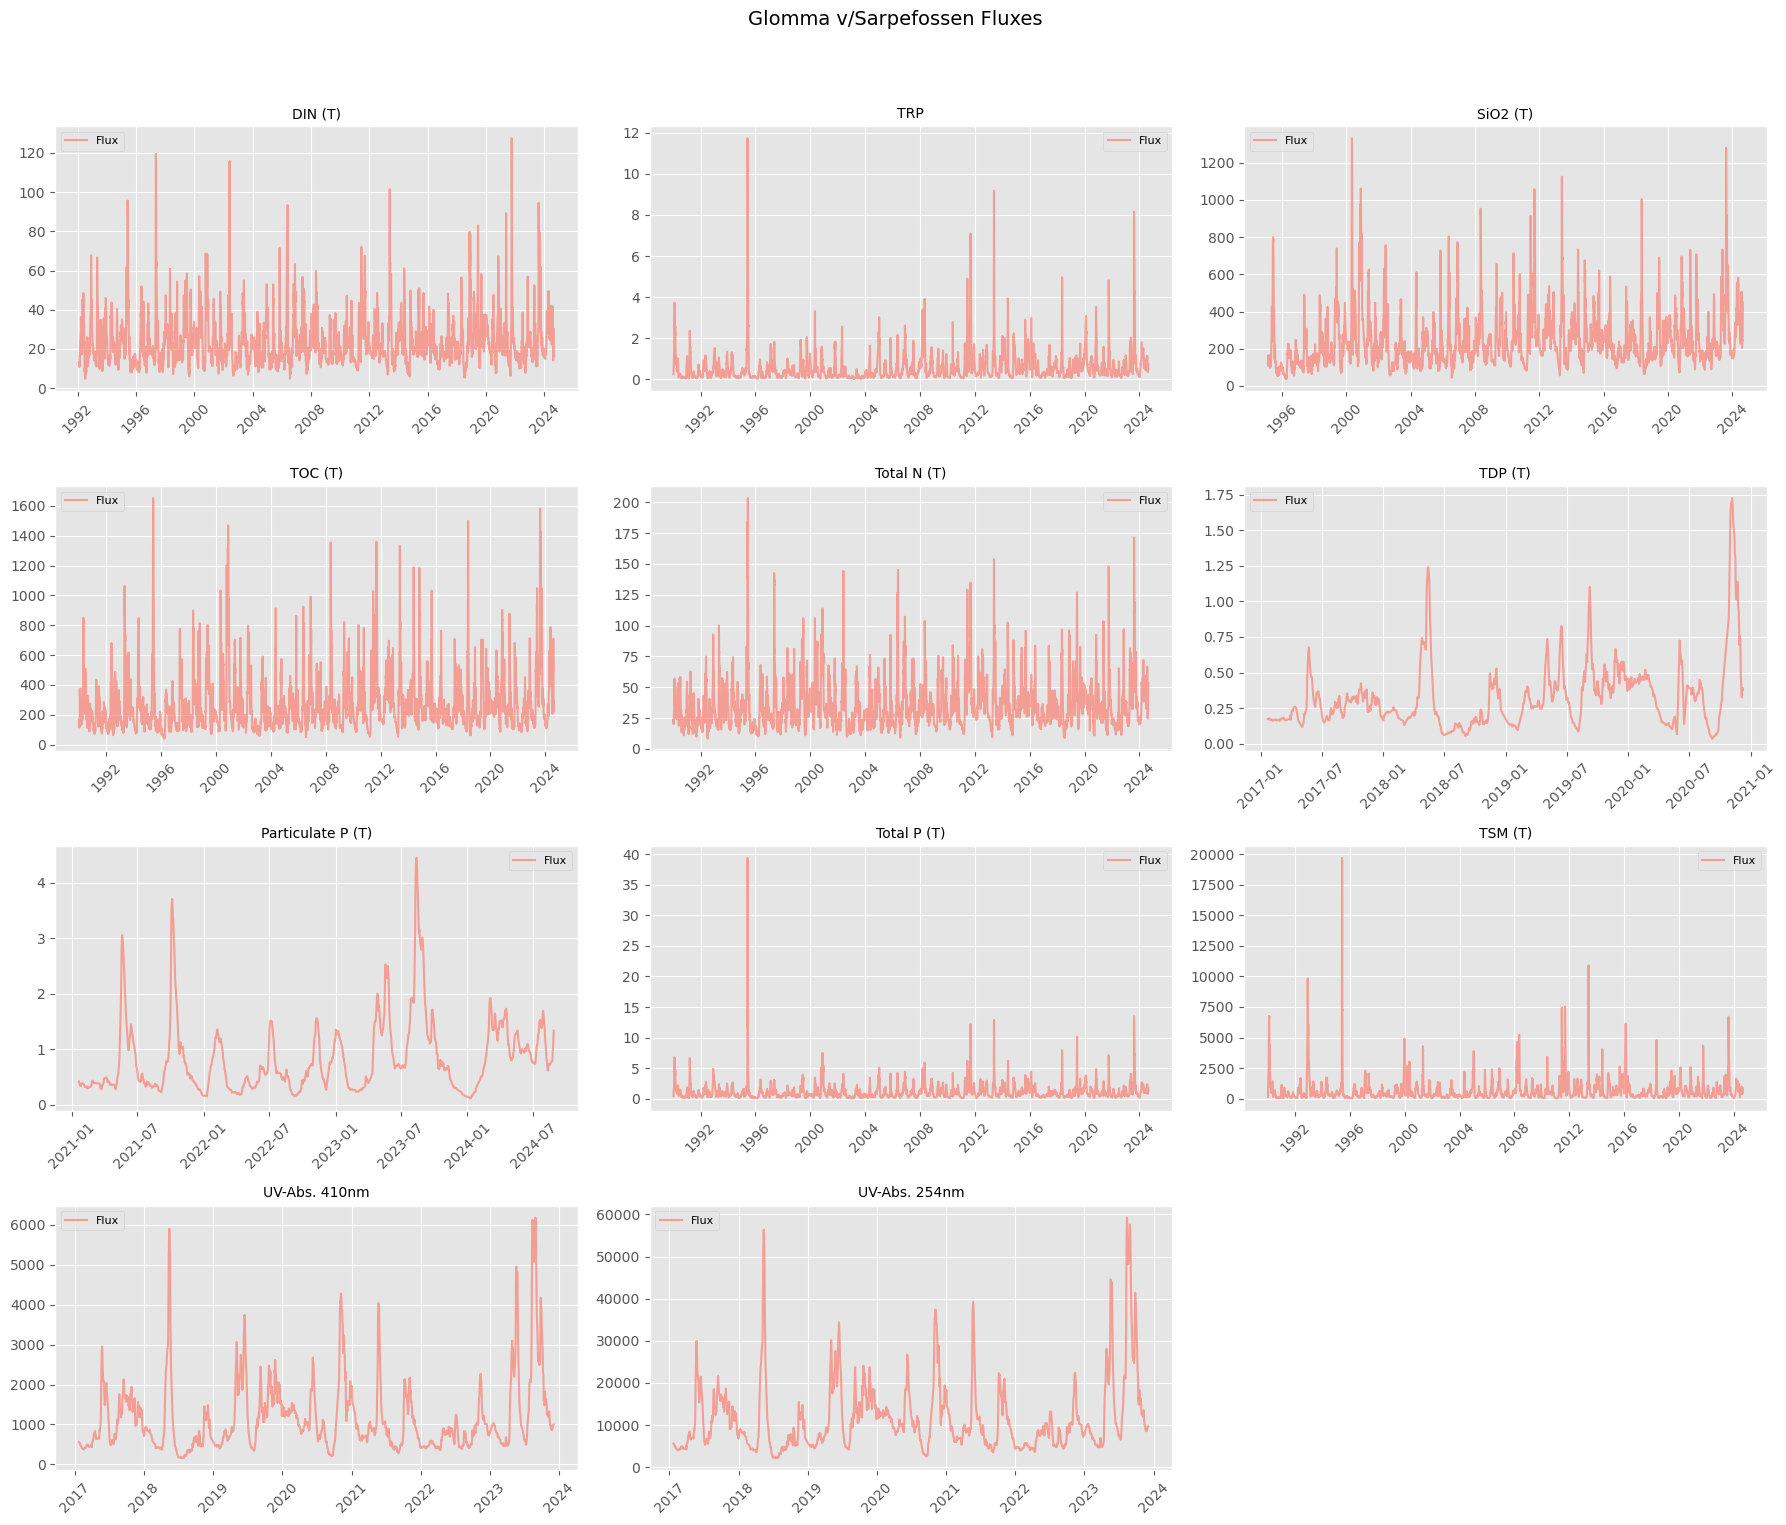

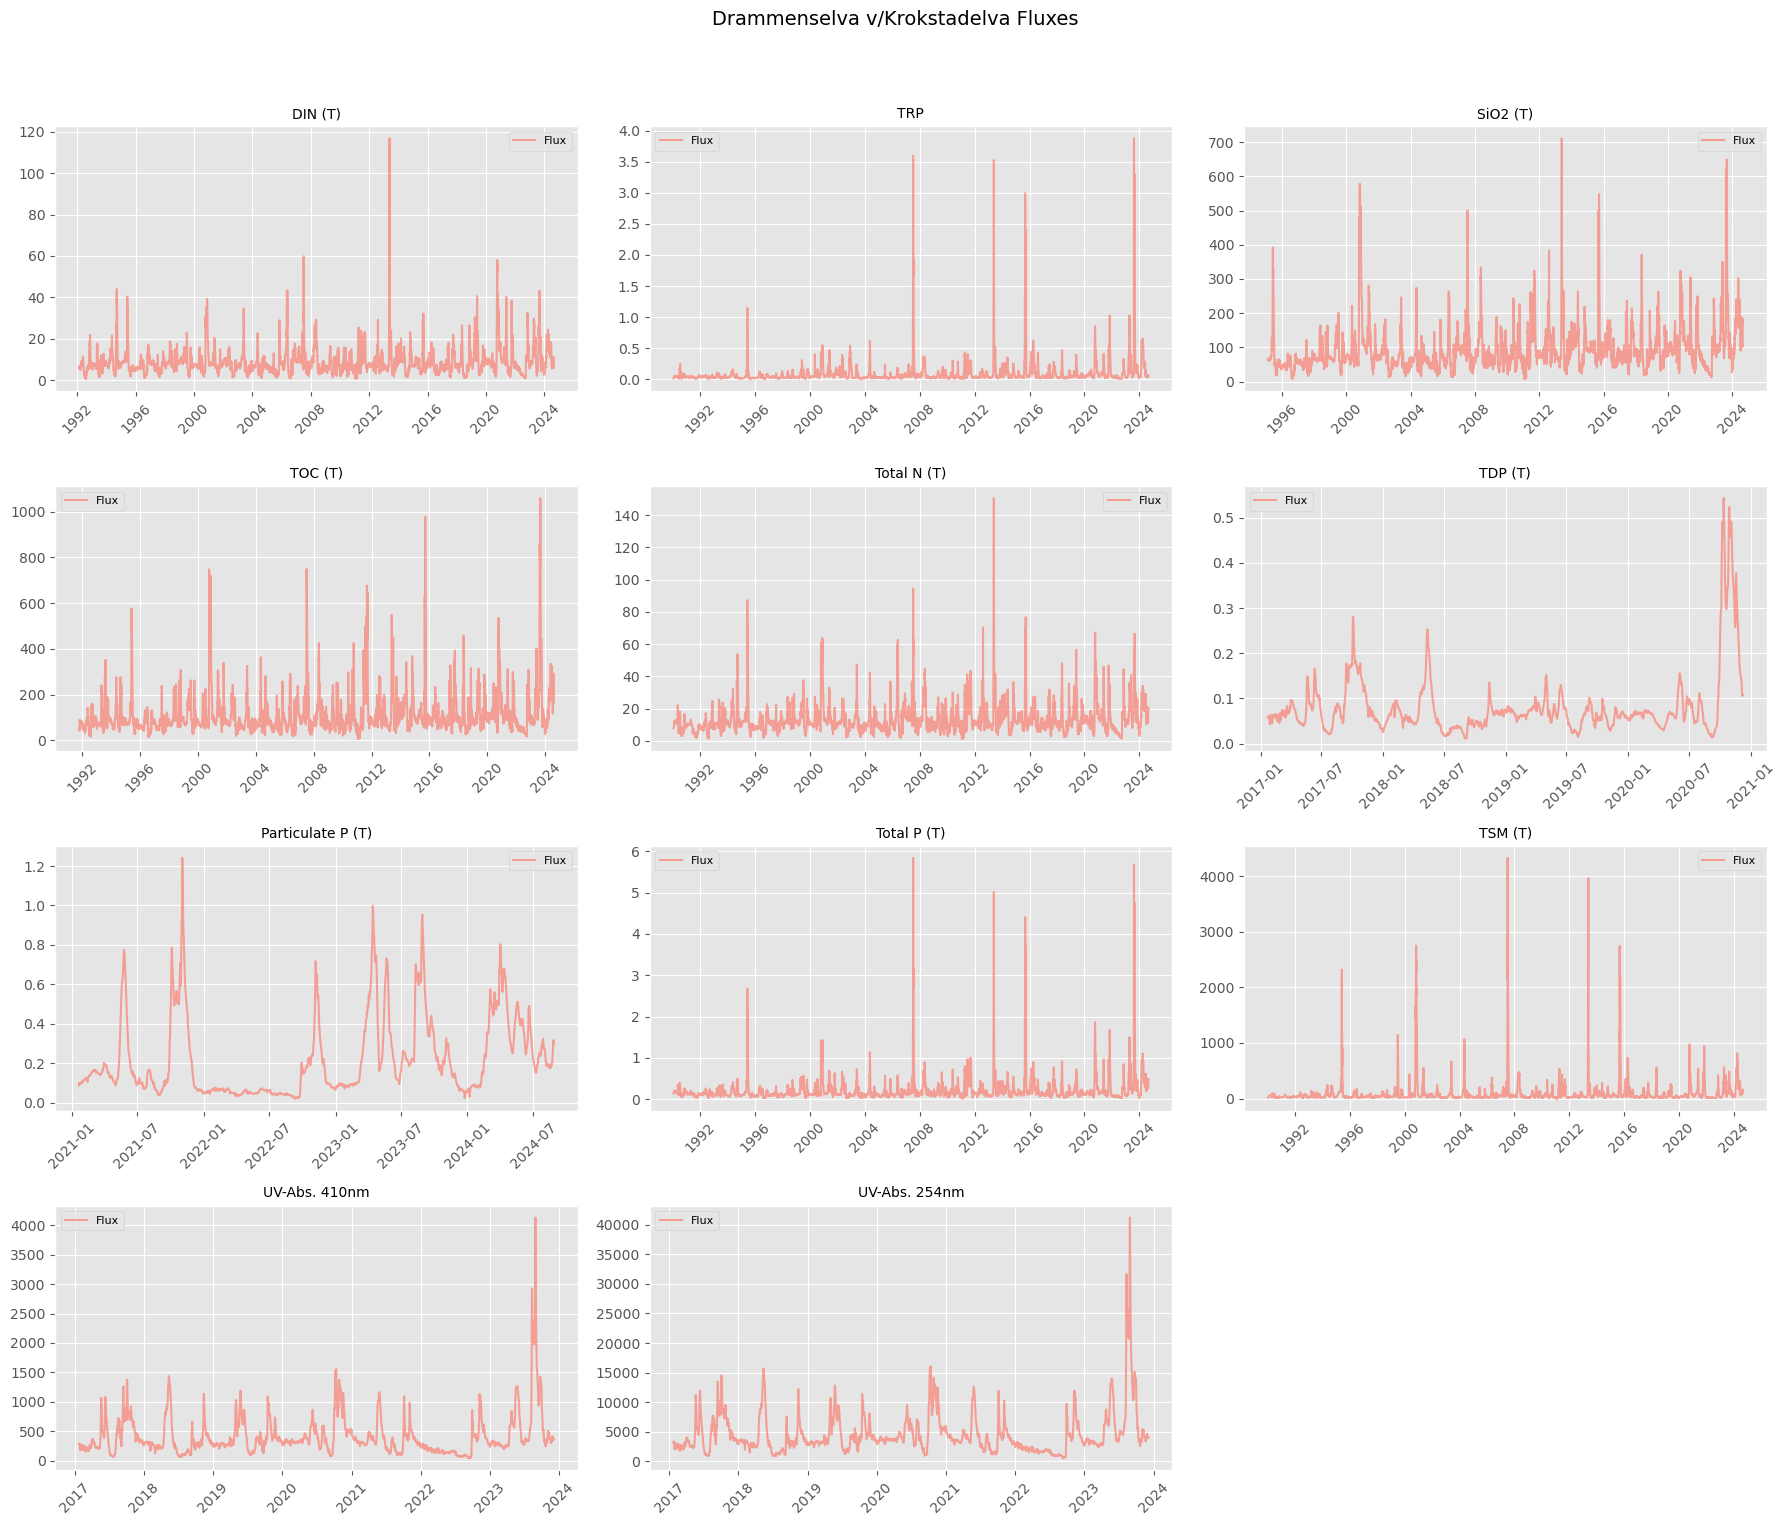

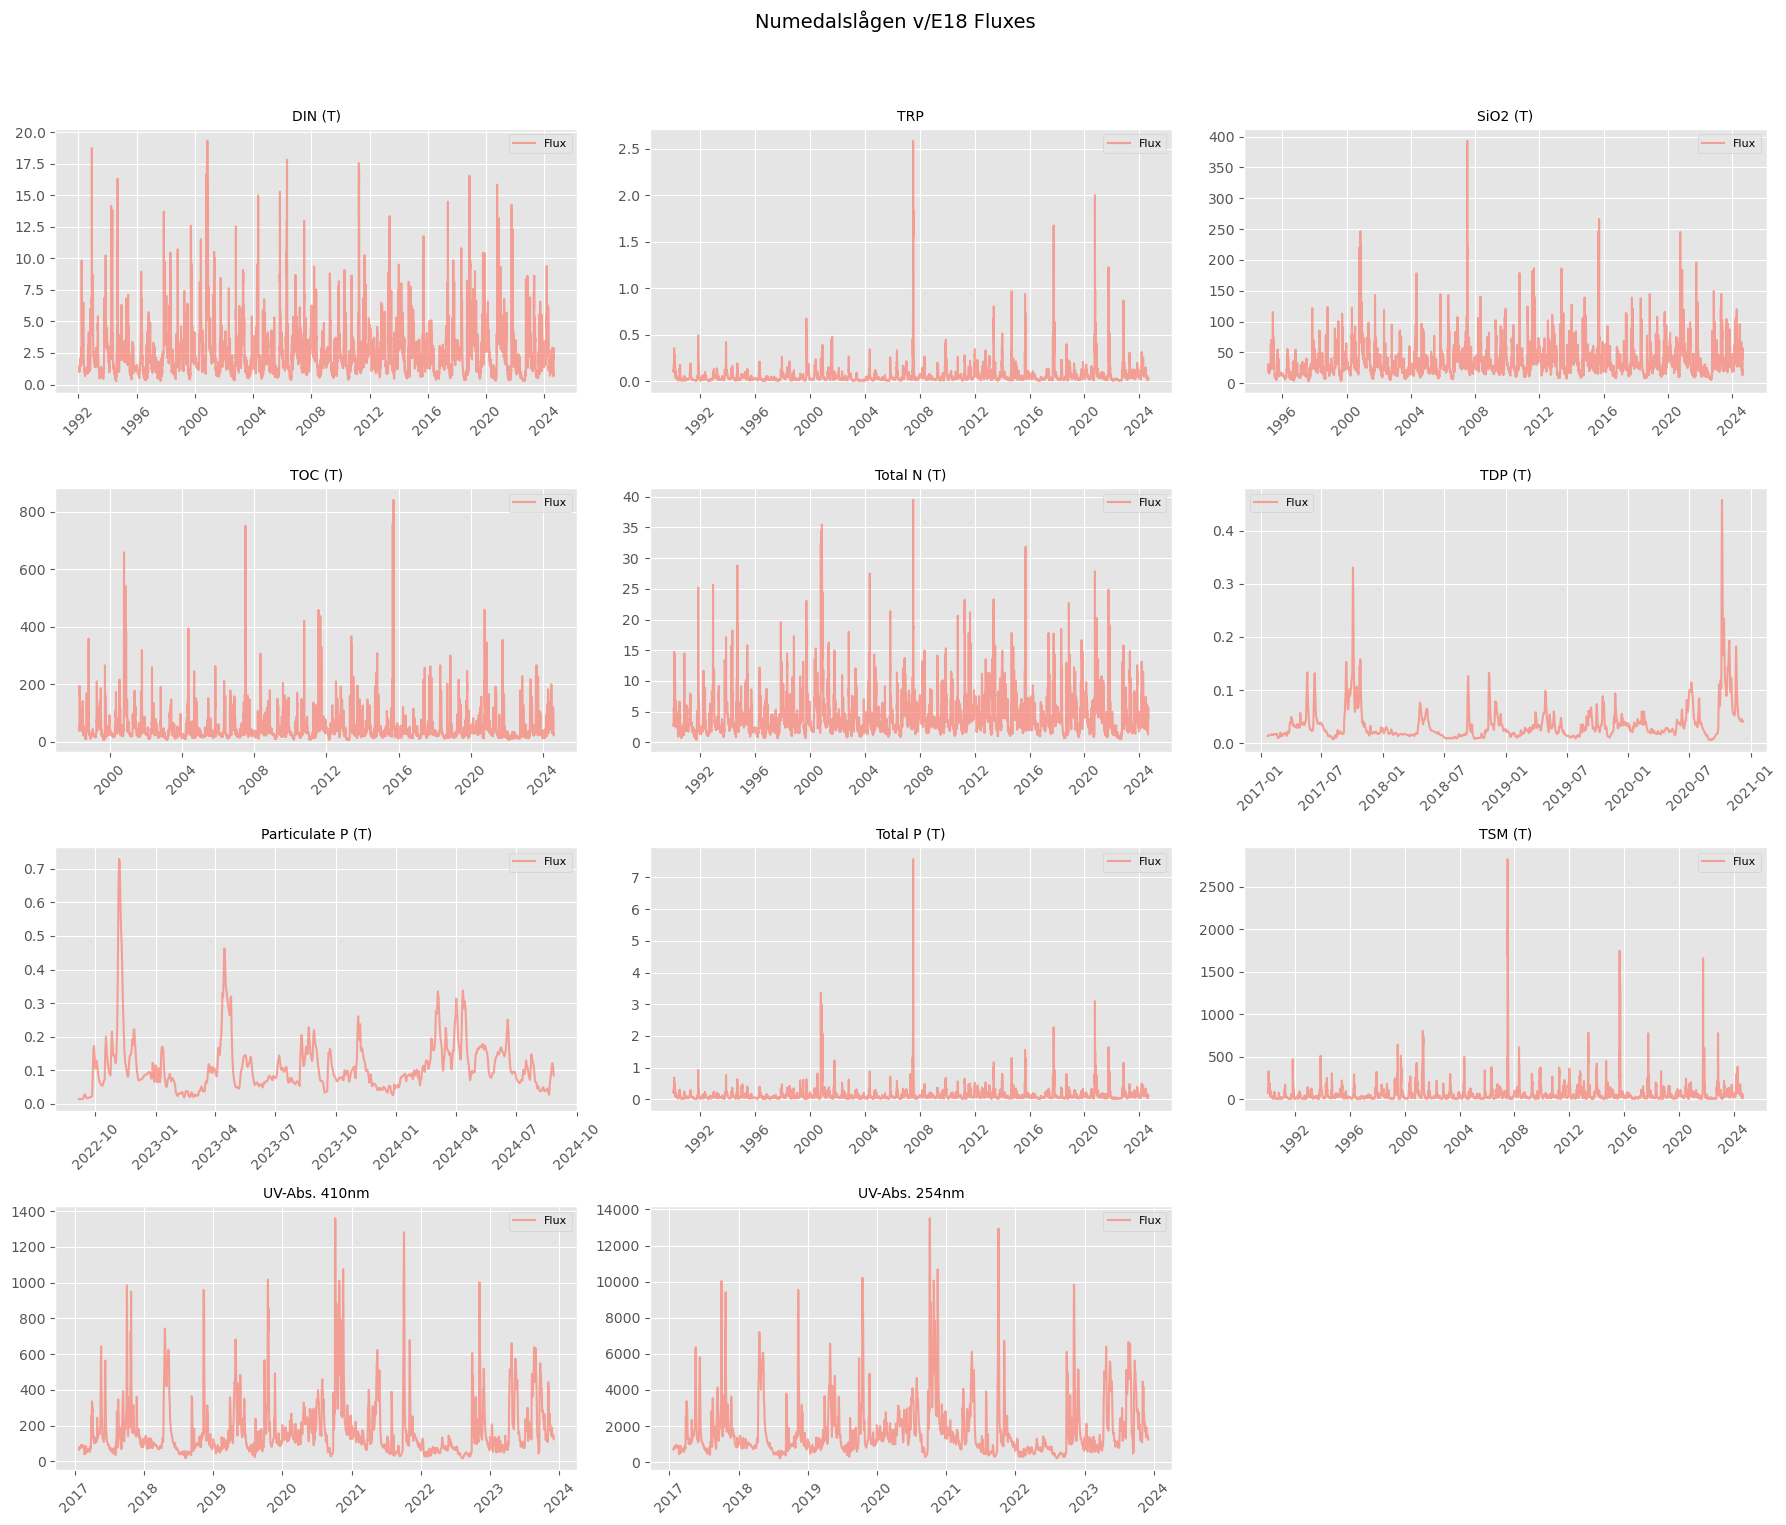

In [56]:
plot_fluxes(daily_flux_dict)

## Monthly

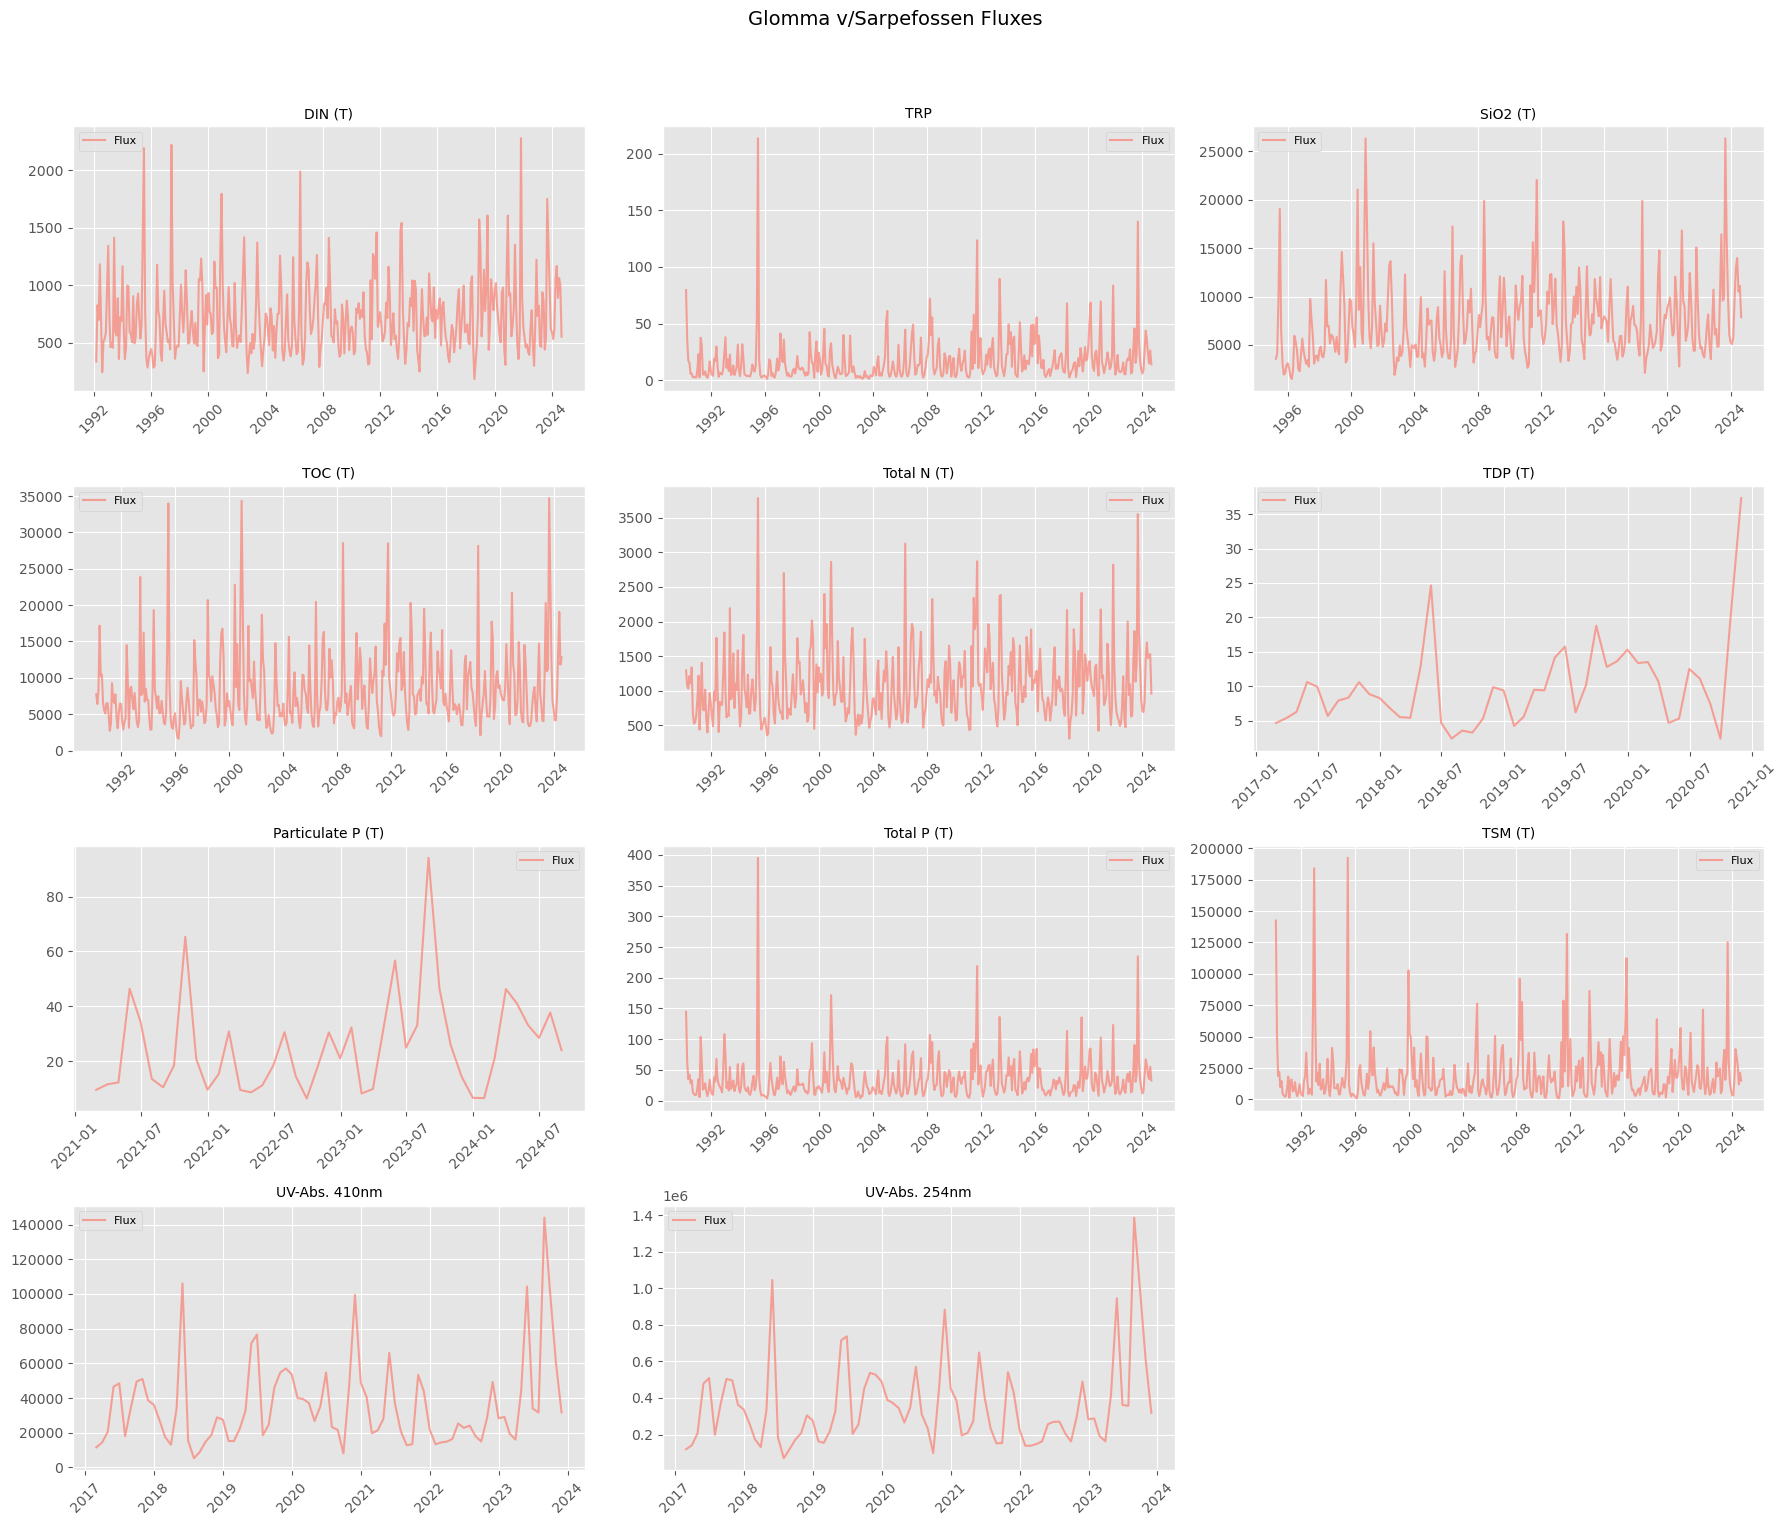

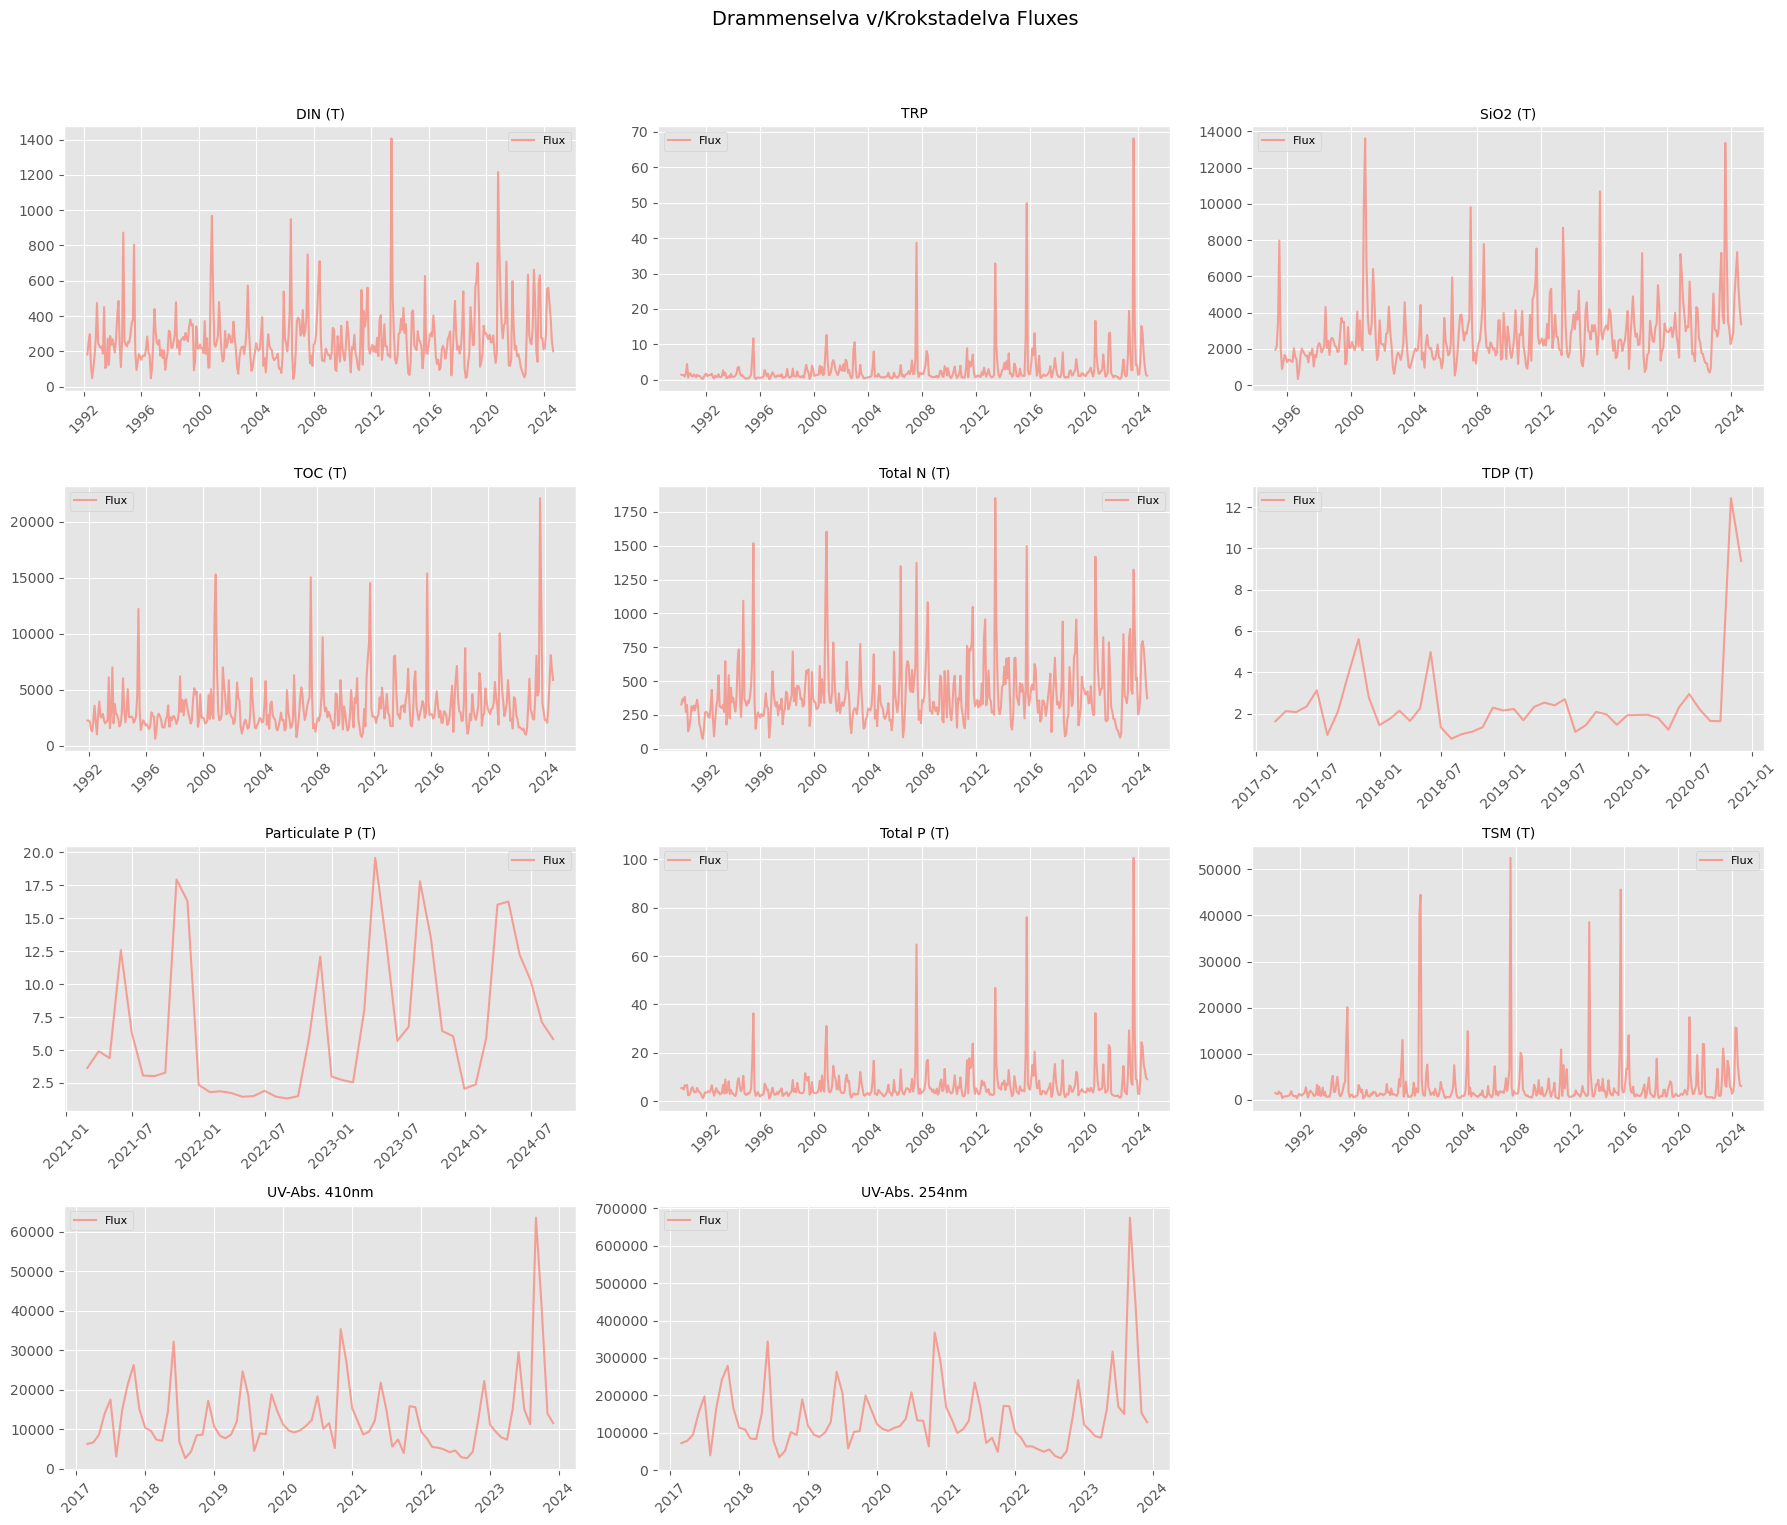

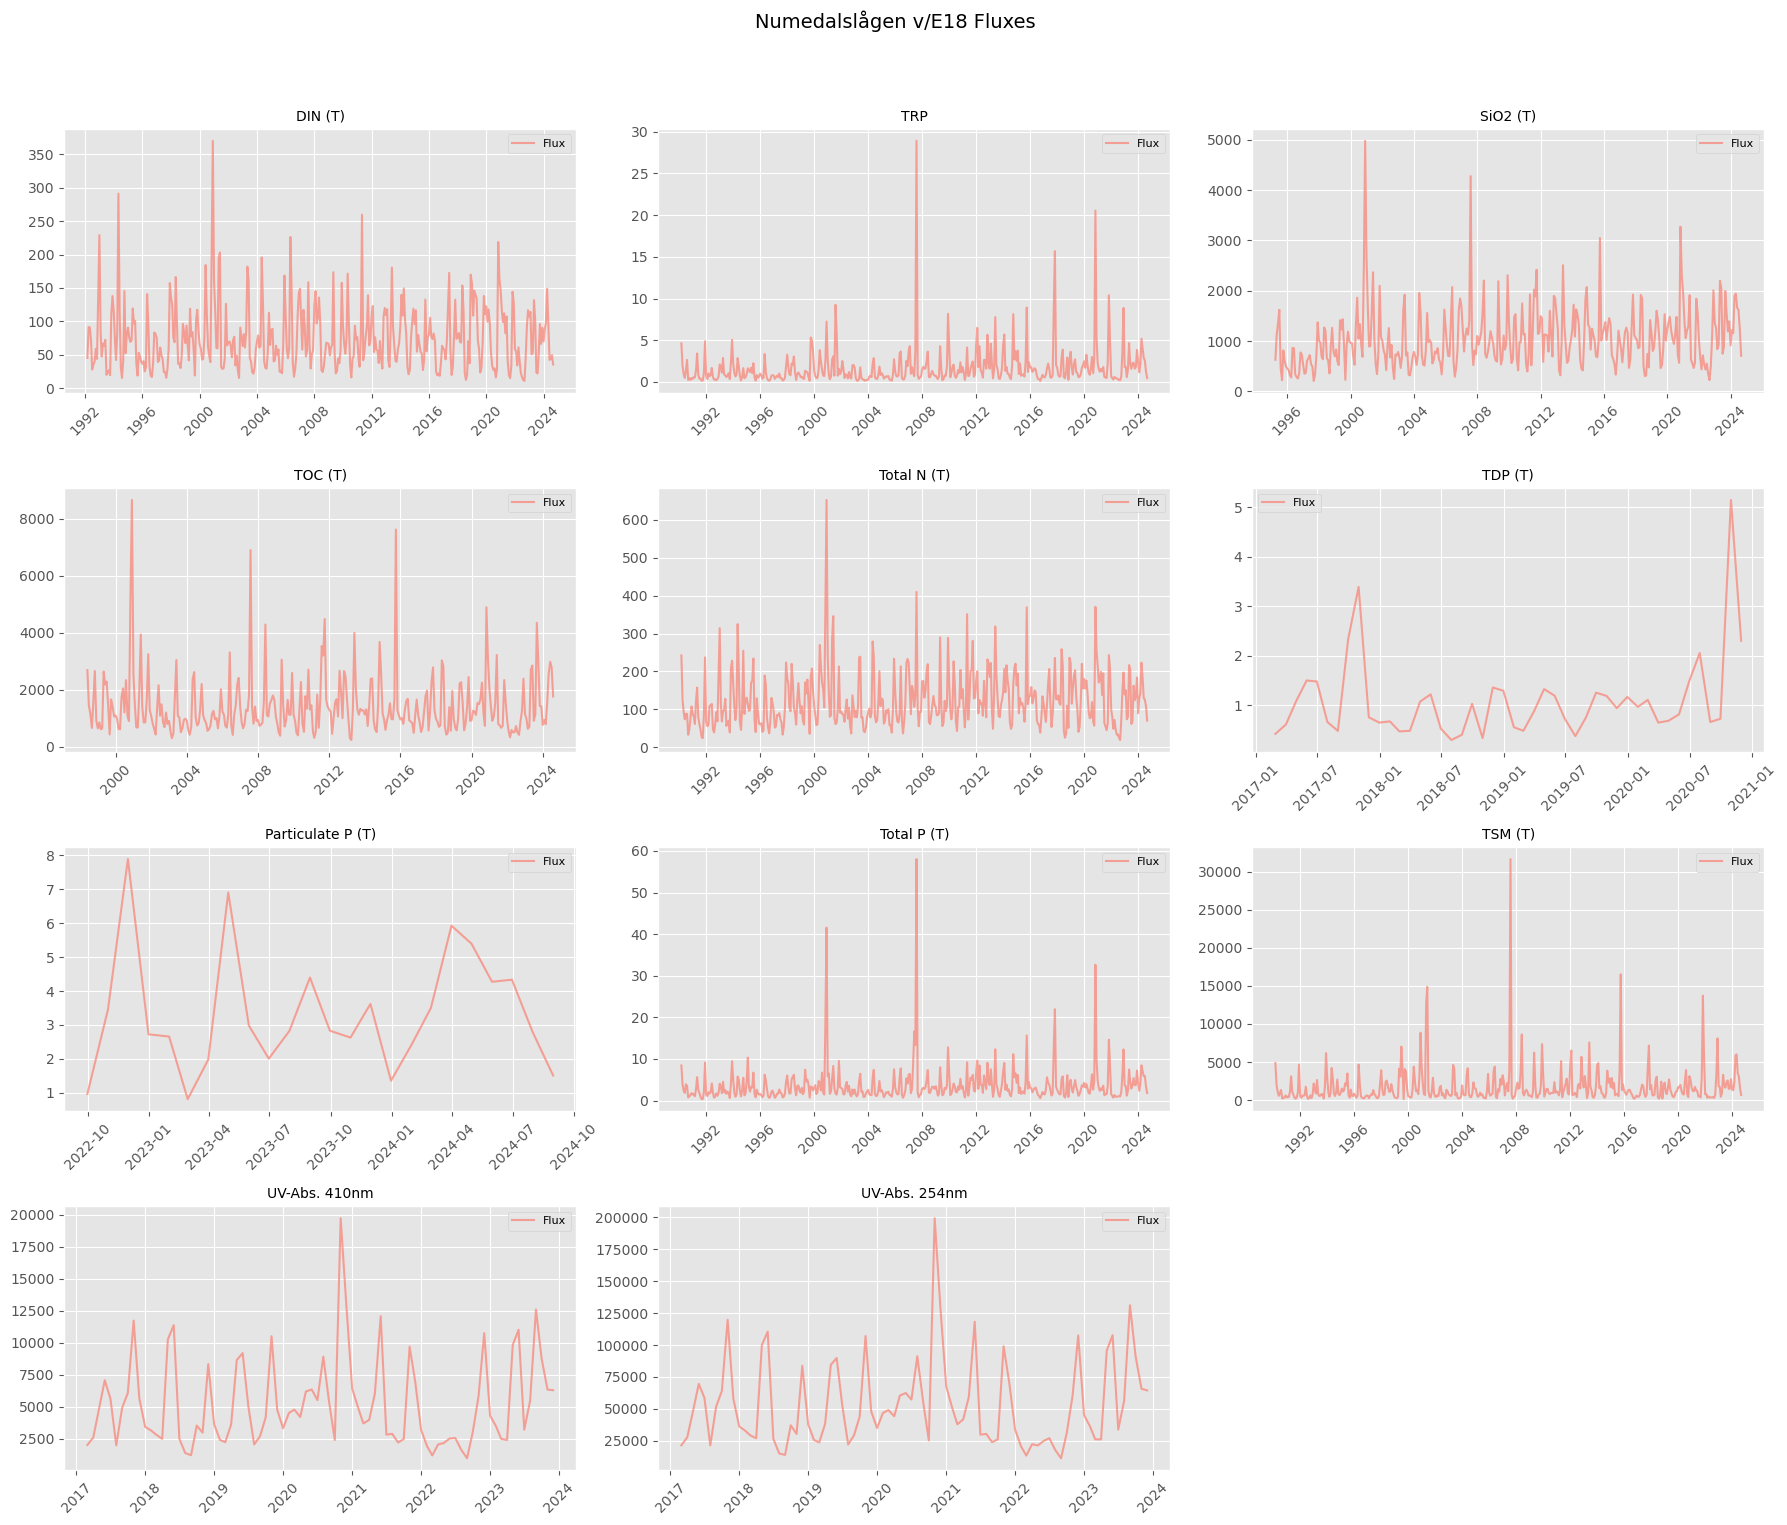

In [58]:
plot_fluxes(monthly_flux_dict)

## Annual

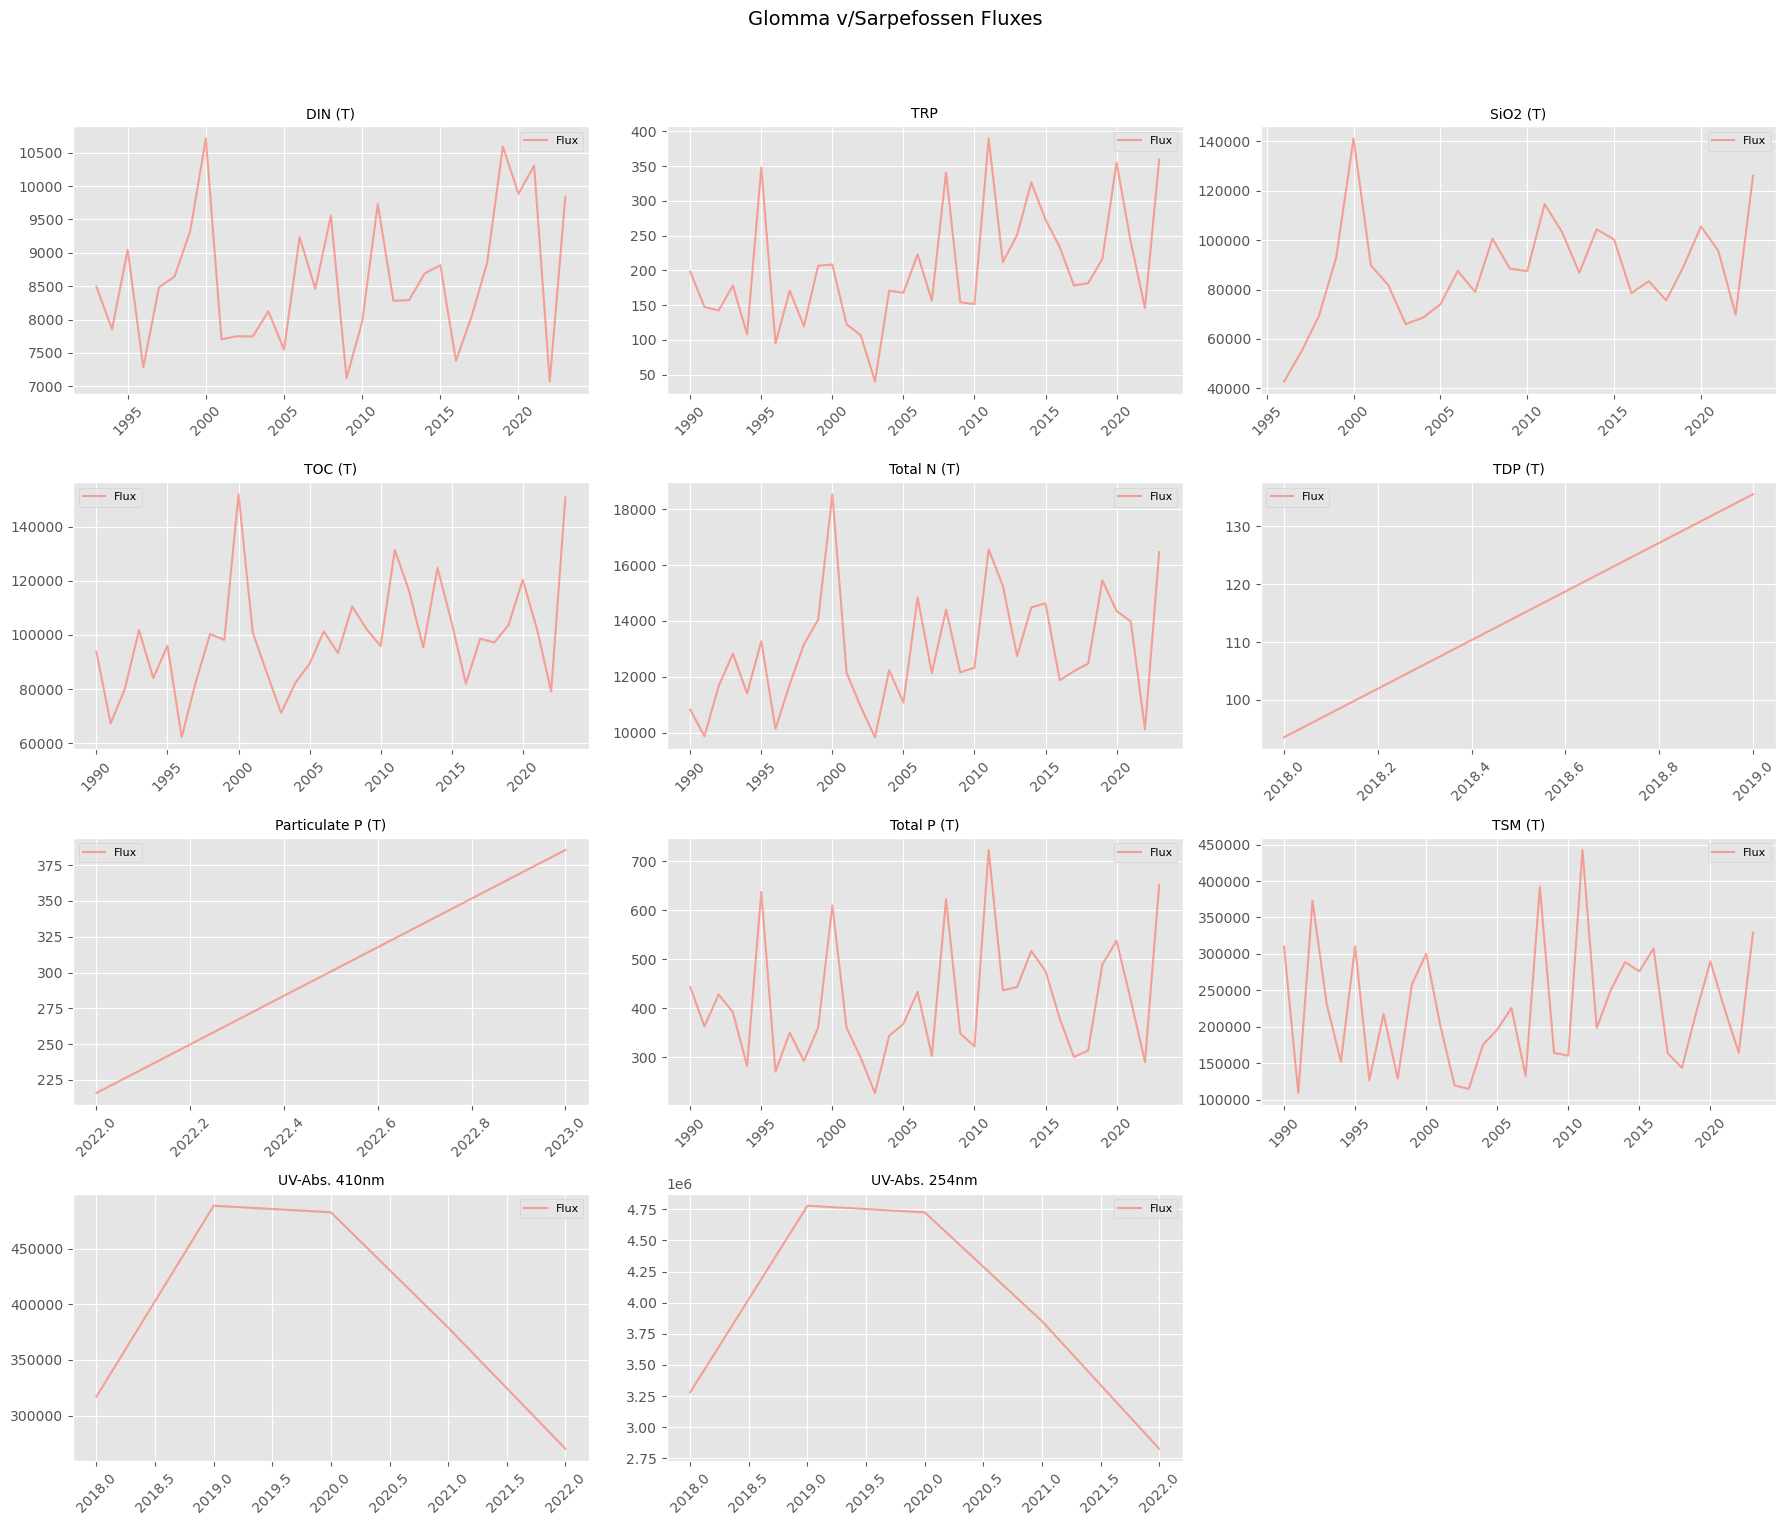

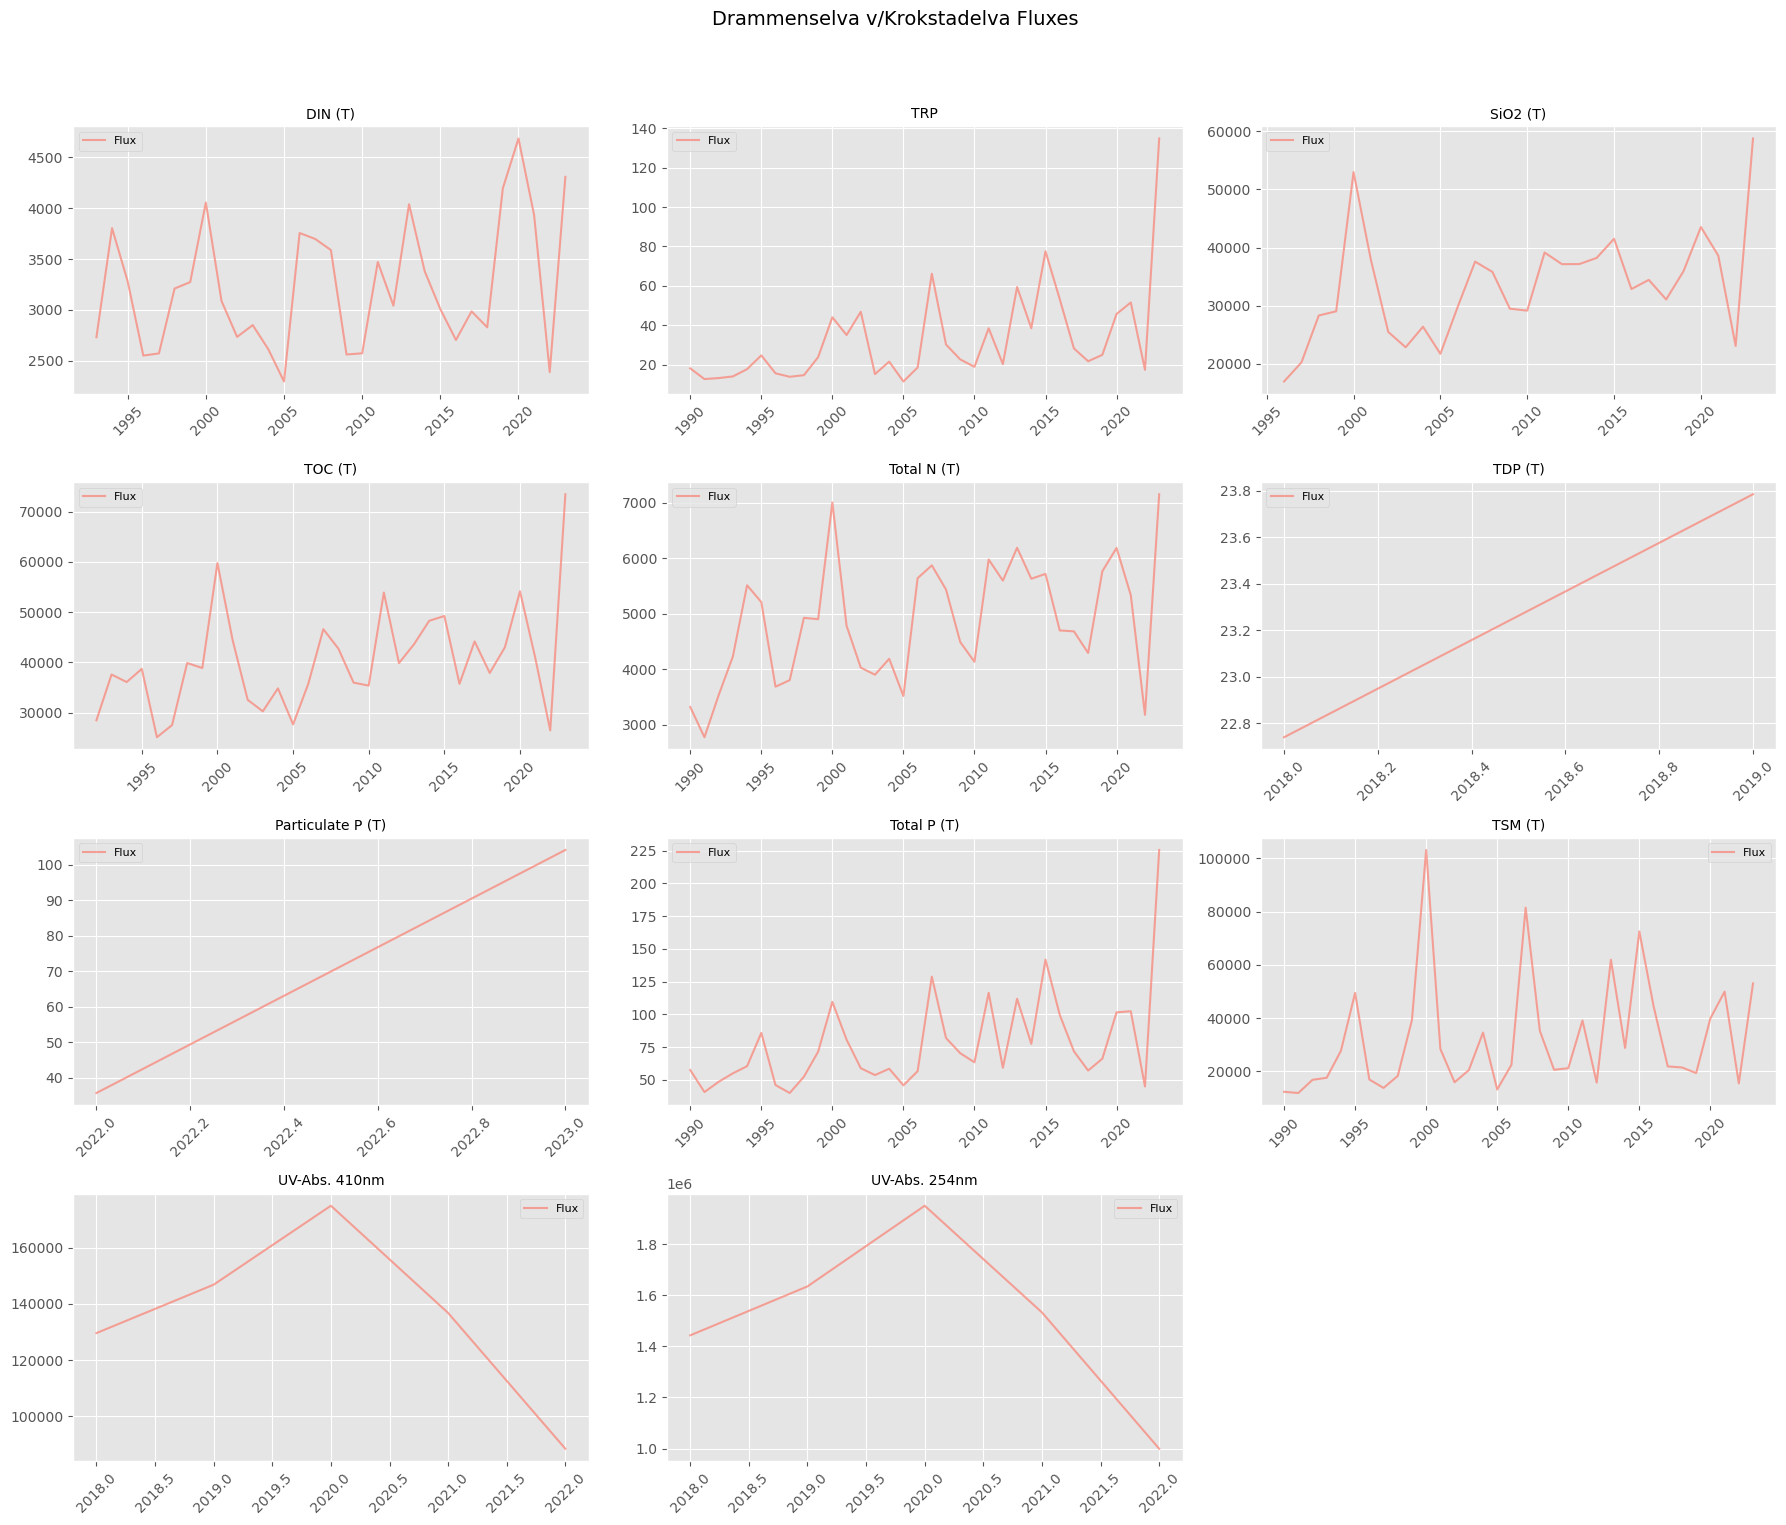

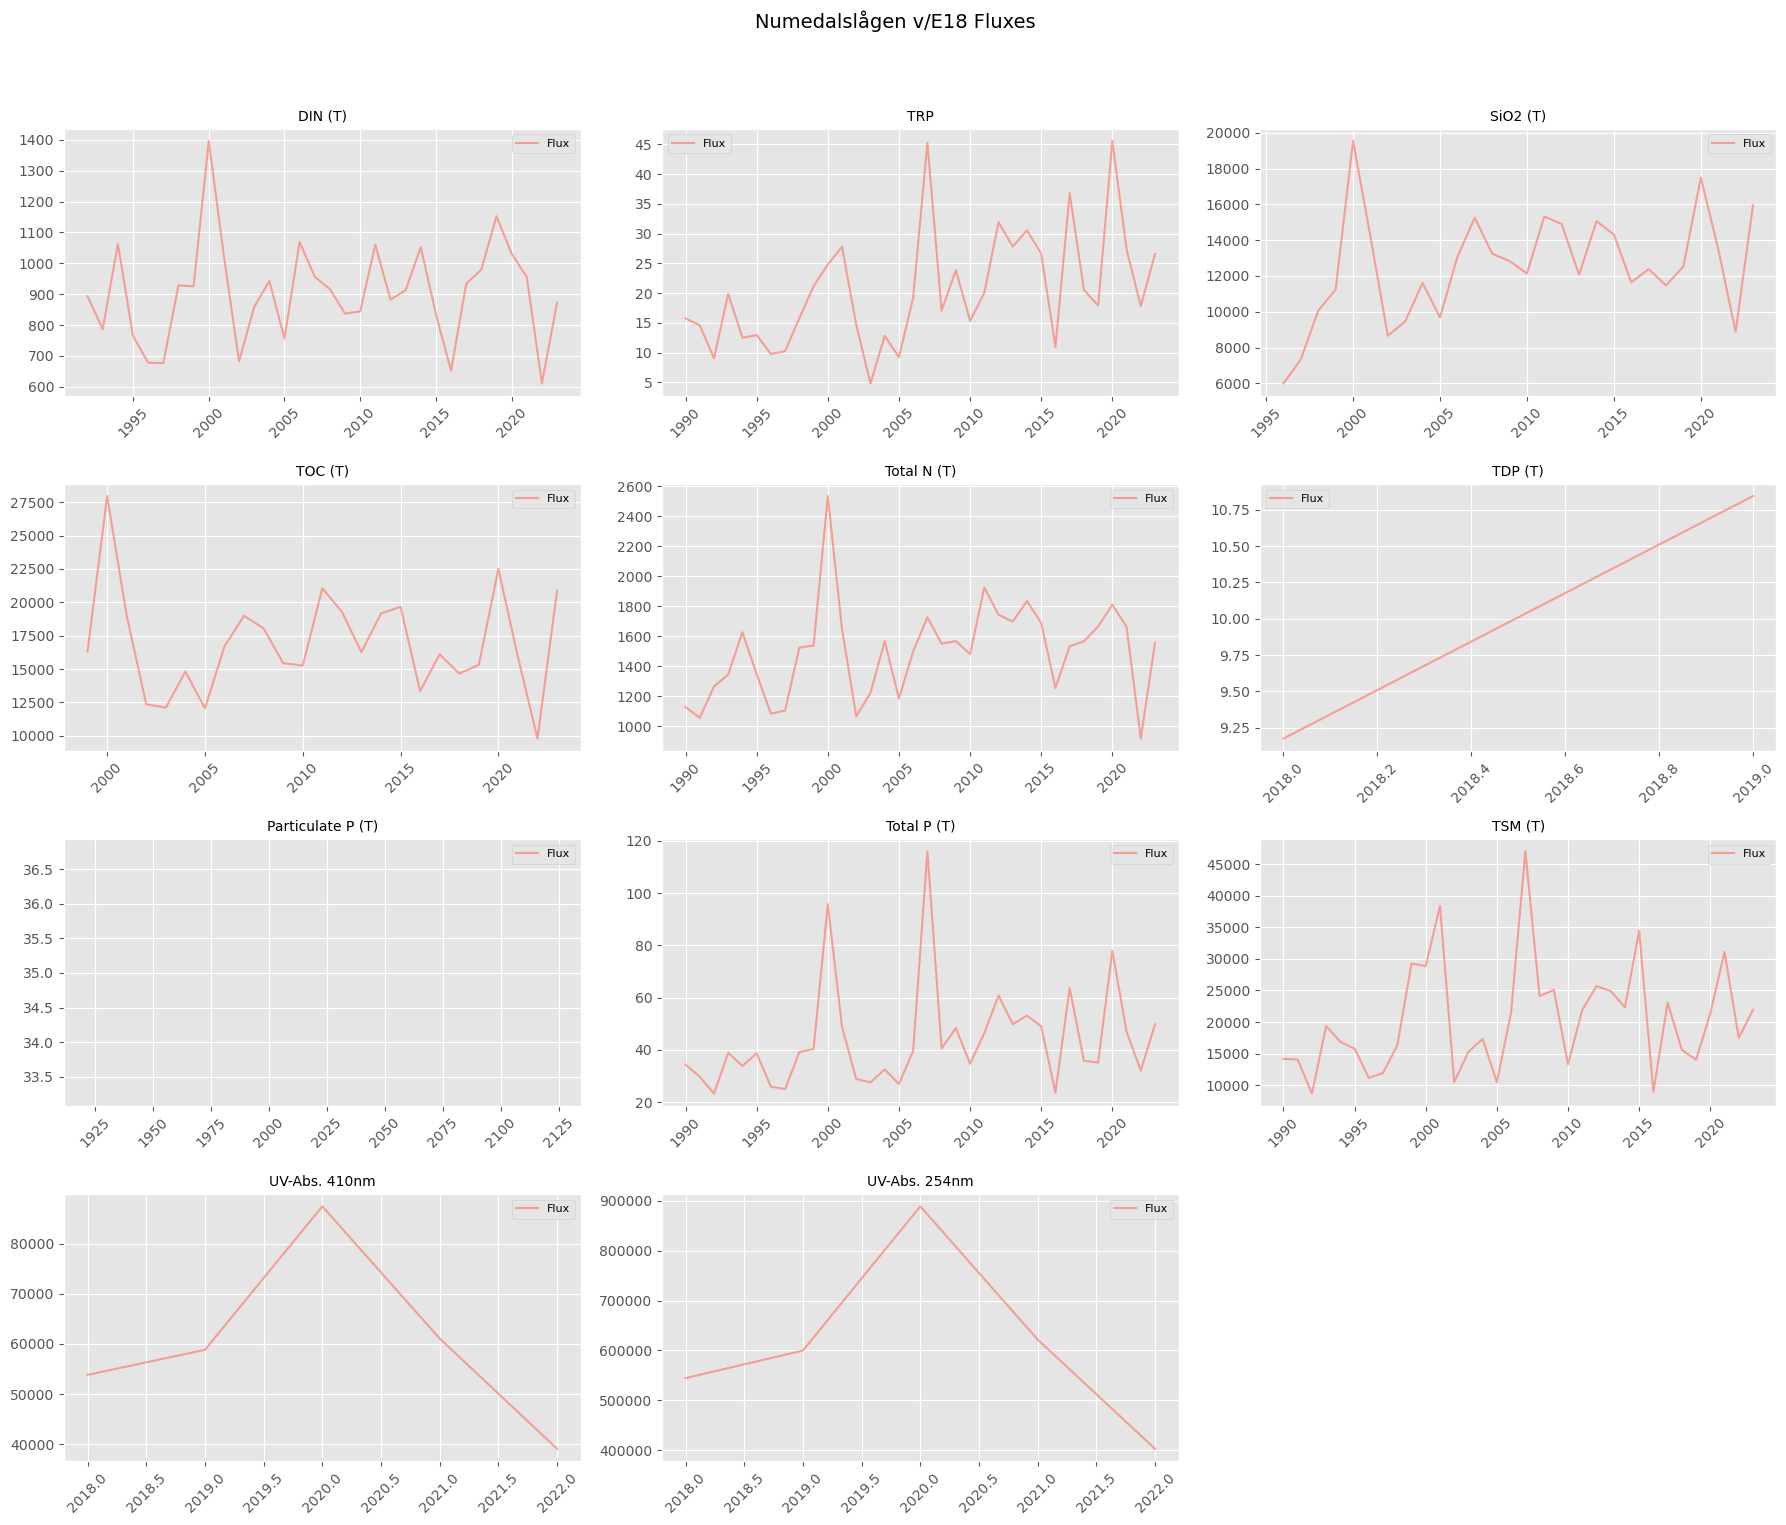

In [59]:
plot_fluxes(annual_flux_dict)